In [99]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

The dataset to be used in this project is a modified version of the dataset create by Paul Clough and Mark Stevenson. The complete description of the data generation process is described in their [research article](https://link.springer.com/article/10.1007/s10579-009-9112-1) (Clough, P., Stevenson, M. Developing a corpus of plagiarised short answers, 2011)

### Description of the dataset

<li> The dataset contains several txt files whose characteristics are summarized in the file_information.csv file. </li>
<li> The dataset has 100 files, out of which 5 are the original answers. Therefore, the participants contributed with 95 anwers, divided in 5 tasks and 5 plagiarism methods. </li>
<li> The <b>File</b> column in the file_information.csv file contains the name of the txt file. </li>
<li> The <b>Task</b> column contains one of the five learning task (A-E) that each txt answers. </li>
<li> The <b>Category</b> column indicates if the participant was asked to use a Near copy (cut), Light revision (light), Heavy revision (heavy) or Non-plagiarised (non) method to answer the question. This column also contains the 'orig' category to reference the original texts on which participants based their answers</li>

In [100]:
data_dir = Path(r"C:\Users\kusha\Downloads\Computational-Tools-for-Data-Science-Group-27-main (1)\Plagiarism Detection")

# load metadata - try the expected filename, otherwise attempt to locate a matching CSV
# use the Path object to build a safe path (avoid backslash escape issues)
target = data_dir / "file_information.csv"

if not target.exists():
	# search for matching csv files in the directory and subdirectories
	matches = list(data_dir.rglob("file_information*.csv")) + list(data_dir.glob("*.csv"))
	if matches:
		# prefer exact name if present, otherwise pick the first match
		for m in matches:
			if m.name == "file_information.csv":
				target = m
				break
		else:
			target = matches[0]
		print(f"Using file: {target}")
	else:
		# helpful debugging output before raising
		print(f"No 'file_information.csv' found in {data_dir}")
		try:
			for p in data_dir.iterdir():
				print(" -", p.name)
		except Exception:
			pass
		raise FileNotFoundError(f"file_information.csv not found in {data_dir}")

summary_data = pd.read_csv(target)
summary_data.head()

Using file: C:\Users\kusha\Downloads\Computational-Tools-for-Data-Science-Group-27-main (1)\Plagiarism Detection\data\file_information.csv


,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


In [101]:
#this is very useful later for evaluating how well the similarity or clustering methods separate plagiarised vs non

#mapping 5-category label to numeric id
category_to_id = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
summary_data['category_id'] = summary_data['Category'].map(category_to_id)

#binary plagiarism label: 1 = plagiarised (cut / light / heavy), 0 = non, -1 = original
def to_plag_label(cat):
    if cat == 'non':
        return 0
    if cat == 'orig':
        return -1
    return 1

summary_data['plag_label'] = summary_data['Category'].apply(to_plag_label)

summary_data.head()


,File,Task,Category,category_id,plag_label
0,g0pA_taska.txt,a,non,0,0
1,g0pA_taskb.txt,b,cut,3,1
2,g0pA_taskc.txt,c,light,2,1
3,g0pA_taskd.txt,d,heavy,1,1
4,g0pA_taske.txt,e,non,0,0


In [102]:
#preprocessing functions

#load raw text and create a cleaned version
def read_file_text(path):
    # accept None/empty path and return empty string instead of raising
    if not path:
        return ""
    p = Path(path)
    if not p.exists():
        print(f"Warning: file not found: {p}")
        return ""
    # read file as raw text for sentence embeddings
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def resolve_file_path(filename):
    """
    Attempt several likely locations for the text files:
      - data_dir / filename
      - data_dir / 'data' / filename
      - data_dir / 'texts' / filename
      - data_dir / 'files' / filename
    Falls back to a recursive search under data_dir by name.
    Returns a Path or None.
    """
    candidates = [
        data_dir / filename,
        data_dir / "data" / filename,
        data_dir / "texts" / filename,
        data_dir / "files" / filename,
    ]
    for c in candidates:
        if c.exists():
            return c
    # if filename itself is a path that exists
    p = Path(filename)
    if p.exists():
        return p
    # try a recursive search (this may be a bit slower but is robust)
    try:
        for c in data_dir.rglob(filename):
            return c
    except Exception:
        pass
    # not found
    print(f"Warning: could not locate file {filename} in {data_dir}")
    return None

def clean_text(text):
    #basic cleaning for tfidf and hashing - convert text to lowercase, remove punctuation, and tidy the whitespace
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", " ", text)   #remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  #normalising whitespace
    return text

#raw text keeps punctuation - for sentence embeddings
summary_data["raw_text"] = summary_data["File"].apply(lambda fn: read_file_text(resolve_file_path(fn)))

#clean text - for tfidf and hashing
summary_data["clean_text"] = summary_data["raw_text"].apply(clean_text)

#save to csv
summary_data.to_csv(data_dir / "preprocessed_dataset.csv", index=False)

summary_data.head()


,File,Task,Category,category_id,plag_label,raw_text,clean_text
0,g0pA_taska.txt,a,non,0,0,Inheritance is a basic concept of Object-Orien...,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,1,PageRank is a link analysis algorithm used by ...,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,1,"The vector space model (also called, term vect...",the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,1,Bayes’ theorem was names after Rev Thomas Baye...,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,0,Dynamic Programming is an algorithm design tec...,dynamic programming is an algorithm design tec...


In [103]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [104]:
path = r"C:\Users\kusha\Downloads\Computational-Tools-for-Data-Science-Group-27-main (1)\Plagiarism Detection\data\preprocessed_dataset.csv"

df = pd.read_csv(path)  

print(df.shape)
print(df.columns)


(100, 7)
Index(['File', 'Task', 'Category', 'category_id', 'plag_label', 'raw_text',
       'clean_text'],
      dtype='object')


In [105]:
df = df[df["plag_label"] != -1].reset_index(drop=True)
print(df["plag_label"].value_counts())
print(df["category_id"].value_counts())


plag_label
1    57
0    38
Name: count, dtype: int64
category_id
0    38
3    19
2    19
1    19
Name: count, dtype: int64


In [106]:
#categorical labels
texts = df["clean_text"].astype(str).tolist()
y = df["category_id"].values  


In [107]:
#callling sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

X = model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(X.shape)   

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 384)


In [ ]:
#train-test split with stratification

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y      
)


In [109]:
#logistic regression classifier

clf = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",   
    class_weight="balanced",     
    n_jobs=-1
)

clf.fit(X_train, y_train)


c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [110]:
#prediction and evaluation

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.47368421052631576

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.40      0.50      0.44         4
           2       0.00      0.00      0.00         4
           3       0.25      0.50      0.33         4

    accuracy                           0.47        19
   macro avg       0.37      0.43      0.39        19
weighted avg       0.44      0.47      0.45        19


Confusion matrix:
[[5 0 0 2]
 [0 2 0 2]
 [0 2 0 2]
 [1 1 0 2]]


c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [111]:
#more detailed classification report with target names
target_names = ["non", "heavy", "light", "cut"]
print(classification_report(y_test, y_pred, target_names=target_names))



              precision    recall  f1-score   support

         non       0.83      0.71      0.77         7
       heavy       0.40      0.50      0.44         4
       light       0.00      0.00      0.00         4
         cut       0.25      0.50      0.33         4

    accuracy                           0.47        19
   macro avg       0.37      0.43      0.39        19
weighted avg       0.44      0.47      0.45        19



c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

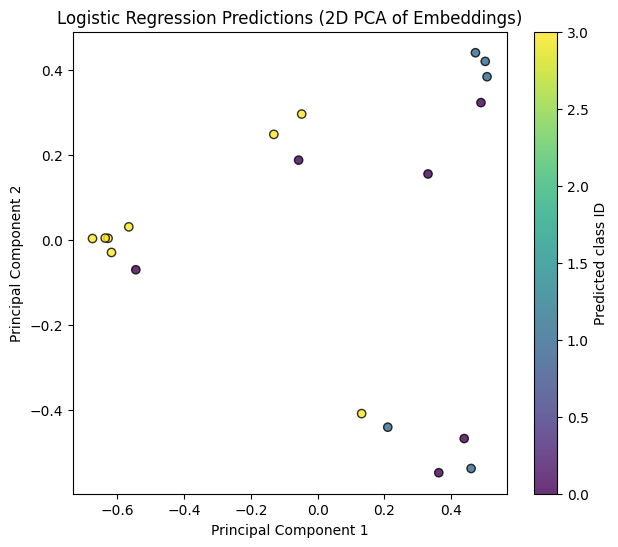

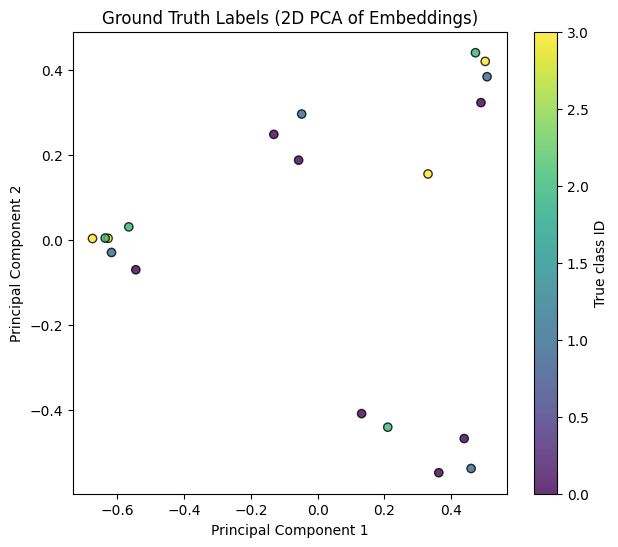

In [112]:
#visualization of predictions vs ground truth 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_test_2d = pca.fit_transform(X_test)

# Get predictions from the trained logistic regression model
y_pred = clf.predict(X_test)

label_map = {0: "non", 1: "heavy", 2: "light", 3: "cut"}
y_pred_names = [label_map[i] for i in y_pred]
y_true_names = [label_map[i] for i in y_test]

# --- Plot 1: Predictions 
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=y_pred,                
    cmap="viridis",
    alpha=0.8,
    edgecolors="k"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Logistic Regression Predictions (2D PCA of Embeddings)")
plt.colorbar(scatter, label="Predicted class ID")
plt.show()

# --- Plot 2: Ground Truth 
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=y_test,                 
    cmap="viridis",
    alpha=0.8,
    edgecolors="k"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Ground Truth Labels (2D PCA of Embeddings)")
plt.colorbar(scatter, label="True class ID")
plt.show()


In [ ]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Logistic Regression Results (Sentence Embeddings)
Accuracy:  0.474
Precision: 0.371
Recall:    0.429
F1-score:  0.387

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.40      0.50      0.44         4
           2       0.00      0.00      0.00         4
           3       0.25      0.50      0.33         4

    accuracy                           0.47        19
   macro avg       0.37      0.43      0.39        19
weighted avg       0.44      0.47      0.45        19



c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

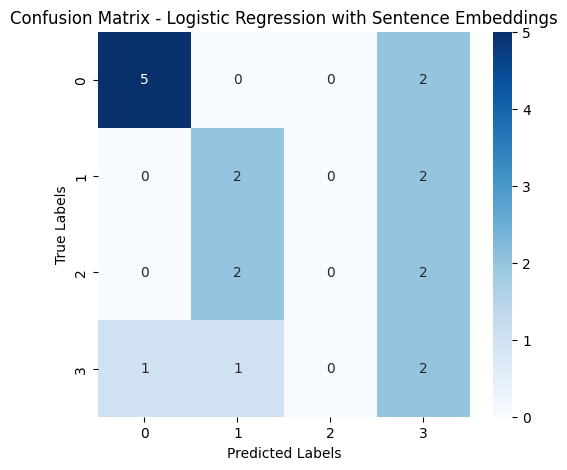


=== Comparison Table ===
                                   Model  Accuracy  Precision   Recall  F1-score
Sentence Embedding + Logistic Regression  0.473684   0.370833 0.428571  0.386752


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Logistic Regression Results (Sentence Embeddings)")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression with Sentence Embeddings")
plt.show()

#export summary table 
results_table = pd.DataFrame({
    "Model": ["Sentence Embedding + Logistic Regression"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1-score": [f1]
})

print("\n=== Comparison Table ===")
print(results_table.to_string(index=False))
